<a href="https://colab.research.google.com/github/Zunuoh/Dengue-Fever-Prediction/blob/main/New_Dengue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

In [ ]:
df = pd.read_csv('climate_disease_dataset.csv')
df.head()

,year,month,country,region,avg_temp_c,precipitation_mm,air_quality_index,uv_index,malaria_cases,dengue_cases,population_density,healthcare_budget
0,2000,1,Palestinian Territory,Central,28.132,152.084,110.487,12.000,53,145,113,1068
1,2000,2,Palestinian Territory,Central,30.886,119.591,83.468,12.000,132,48,113,1068
2,2000,3,Palestinian Territory,Central,31.366,95.876,93.095,12.000,34,80,113,1068
3,2000,4,Palestinian Territory,Central,28.482,175.316,105.530,9.396,23,133,113,1068
4,2000,5,Palestinian Territory,Central,26.890,191.446,60.206,9.936,39,74,113,1068


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,34560.000,2011.500,6.922,2000.000,2005.750,2011.500,2017.250,2023.000
month,34560.000,6.500,3.452,1.000,3.750,6.500,9.250,12.000
avg_temp_c,34560.000,20.395,8.411,-2.557,14.404,20.352,26.343,44.584
precipitation_mm,34560.000,192.668,90.504,0.000,124.641,195.315,260.148,485.704
air_quality_index,34560.000,43.788,33.080,0.000,15.323,40.686,68.402,168.848
uv_index,34560.000,10.211,1.937,0.871,8.921,10.761,12.000,12.000
malaria_cases,34560.000,70.520,46.131,0.000,32.000,69.000,107.000,201.000
dengue_cases,34560.000,75.941,37.324,0.000,48.000,76.000,104.000,181.000
population_density,34560.000,266.900,136.001,50.000,136.250,277.500,384.750,498.000
healthcare_budget,34560.000,2764.650,1418.119,205.000,1435.500,2859.000,3996.750,4969.000


In [ ]:
df.isnull().sum()

,0
year,0
month,0
country,0
region,0
avg_temp_c,0
precipitation_mm,0
air_quality_index,0
uv_index,0
malaria_cases,0
dengue_cases,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                34560 non-null  int64  
 1   month               34560 non-null  int64  
 2   country             34560 non-null  object 
 3   region              34560 non-null  object 
 4   avg_temp_c          34560 non-null  float64
 5   precipitation_mm    34560 non-null  float64
 6   air_quality_index   34560 non-null  float64
 7   uv_index            34560 non-null  float64
 8   malaria_cases       34560 non-null  int64  
 9   dengue_cases        34560 non-null  int64  
 10  population_density  34560 non-null  int64  
 11  healthcare_budget   34560 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 3.2+ MB


In [ ]:
df['country'] = df['country'].astype('category')
df['region'] = df['region'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   year                34560 non-null  int64   
 1   month               34560 non-null  int64   
 2   country             34560 non-null  category
 3   region              34560 non-null  category
 4   avg_temp_c          34560 non-null  float64 
 5   precipitation_mm    34560 non-null  float64 
 6   air_quality_index   34560 non-null  float64 
 7   uv_index            34560 non-null  float64 
 8   malaria_cases       34560 non-null  int64   
 9   dengue_cases        34560 non-null  int64   
 10  population_density  34560 non-null  int64   
 11  healthcare_budget   34560 non-null  int64   
dtypes: category(2), float64(4), int64(6)
memory usage: 2.7 MB


In [ ]:
region_dummies = pd.get_dummies(df['region'], prefix="region")
country_dummies = pd.get_dummies(df['country'], prefix='country')

df = pd.concat([df, region_dummies, country_dummies], axis=1)

In [ ]:
X = df.drop(['dengue_cases', 'year'], axis=1)
y = df['dengue_cases']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
country_columns = [col for col in df.columns if col.startswith('country_')]
country_cases = df[country_columns].multiply(df['dengue_cases'], axis=0).sum()
country_cases = country_cases.reset_index()
country_cases.columns = ['Country', 'Total Cases']


region_columns = [col for col in df.columns if col.startswith('region_')]
region_cases = df[region_columns].multiply(df['dengue_cases'], axis=0).sum()
region_cases = region_cases.reset_index()
region_cases.columns = ['Region', 'Total Cases']

In [67]:
print(country_columns)
print(region_columns)

['country_American Samoa', 'country_Antarctica (the territory South of 60 deg S)', 'country_Antigua and Barbuda', 'country_Armenia', 'country_Aruba', 'country_Azerbaijan', 'country_Bahamas', 'country_Bangladesh', 'country_Barbados', 'country_Belgium', 'country_Brazil', 'country_Bulgaria', 'country_Burkina Faso', 'country_Cambodia', 'country_Chad', 'country_Chile', 'country_Christmas Island', 'country_Cocos (Keeling) Islands', 'country_Colombia', 'country_Congo', 'country_Cuba', 'country_Cyprus', 'country_Czech Republic', 'country_Denmark', 'country_Djibouti', 'country_Dominica', 'country_Dominican Republic', 'country_Ecuador', 'country_Egypt', 'country_El Salvador', 'country_Estonia', 'country_Ethiopia', 'country_Falkland Islands (Malvinas)', 'country_Fiji', 'country_Finland', 'country_French Guiana', 'country_French Polynesia', 'country_Gabon', 'country_Germany', 'country_Greenland', 'country_Grenada', 'country_Guadeloupe', 'country_Guam', 'country_Guinea-Bissau', 'country_Guyana', 'c

/tmp/ipython-input-38-187660578.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Total Cases', data=country_cases, palette='viridis')


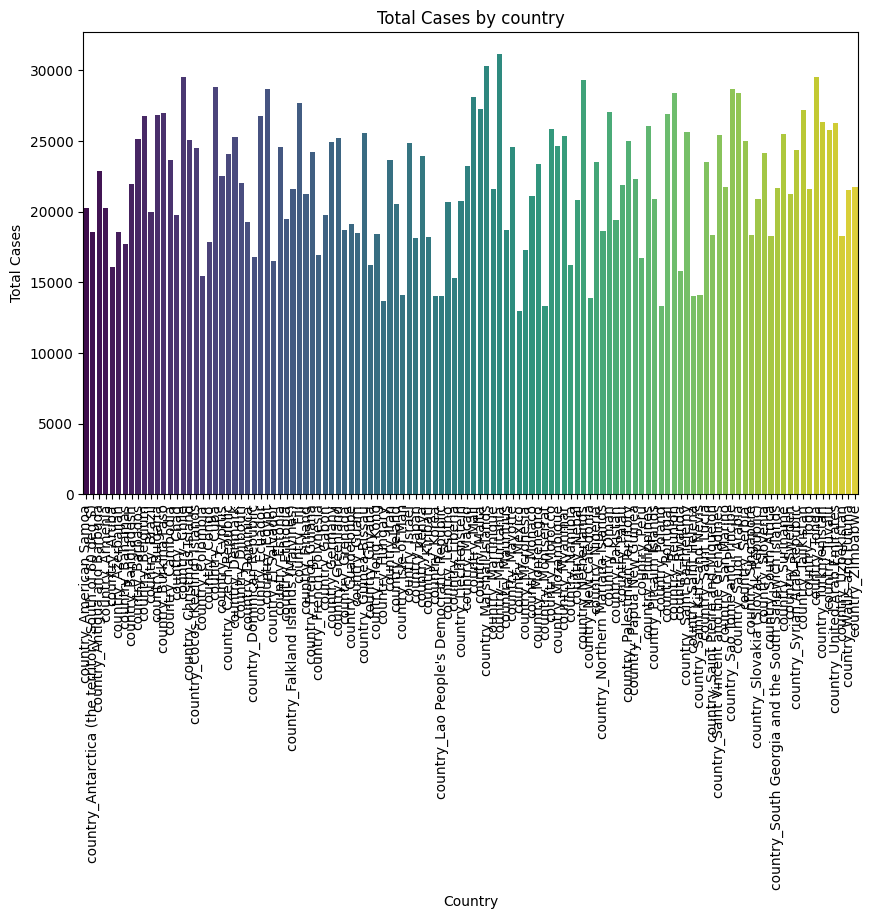

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Total Cases', data=country_cases, palette='viridis')
plt.title('Total Cases by country')
plt.xlabel('Country')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.show()

/tmp/ipython-input-39-4050754346.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Total Cases', data=region_cases, palette='viridis')


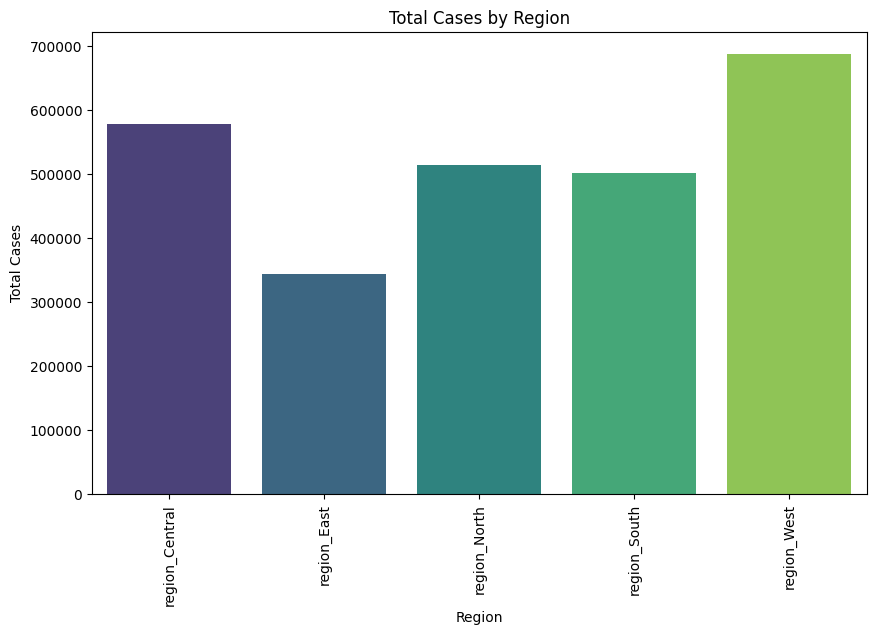

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Total Cases', data=region_cases, palette='viridis')
plt.title('Total Cases by Region')
plt.xlabel('Region')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.show()

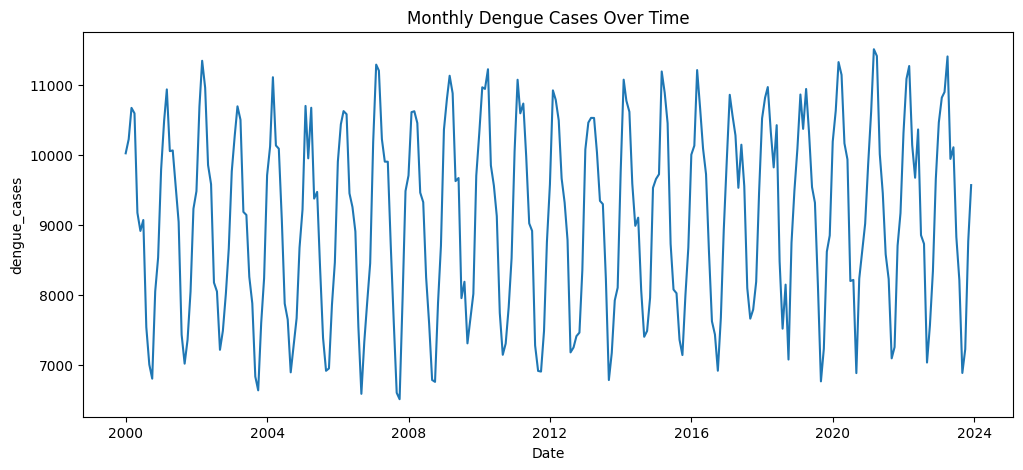

In [ ]:
monthly = df.groupby(['year', 'month'])['dengue_cases'].sum().reset_index()
monthly['Date'] = pd.to_datetime(monthly[['year', 'month']].assign(DAY=1))

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x='Date', y='dengue_cases')
plt.title("Monthly Dengue Cases Over Time")
plt.show()

## **FEATURE ENGINEERING**

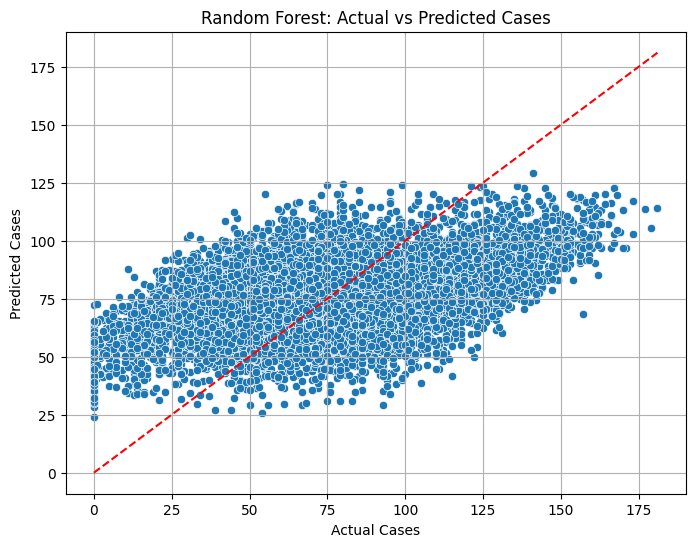

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # ideal line
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Random Forest: Actual vs Predicted Cases")
plt.grid(True)
plt.show()

## **COMPARE PROVINCE CASES TO FACTORS**

In [ ]:
df['Prov'] = df[province_columns].idxmax(axis=1).str.replace('Province_', '')
factors = df.groupby('Prov')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Prov', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Prov', y='Average Value', hue='Factor', palette='viridis')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

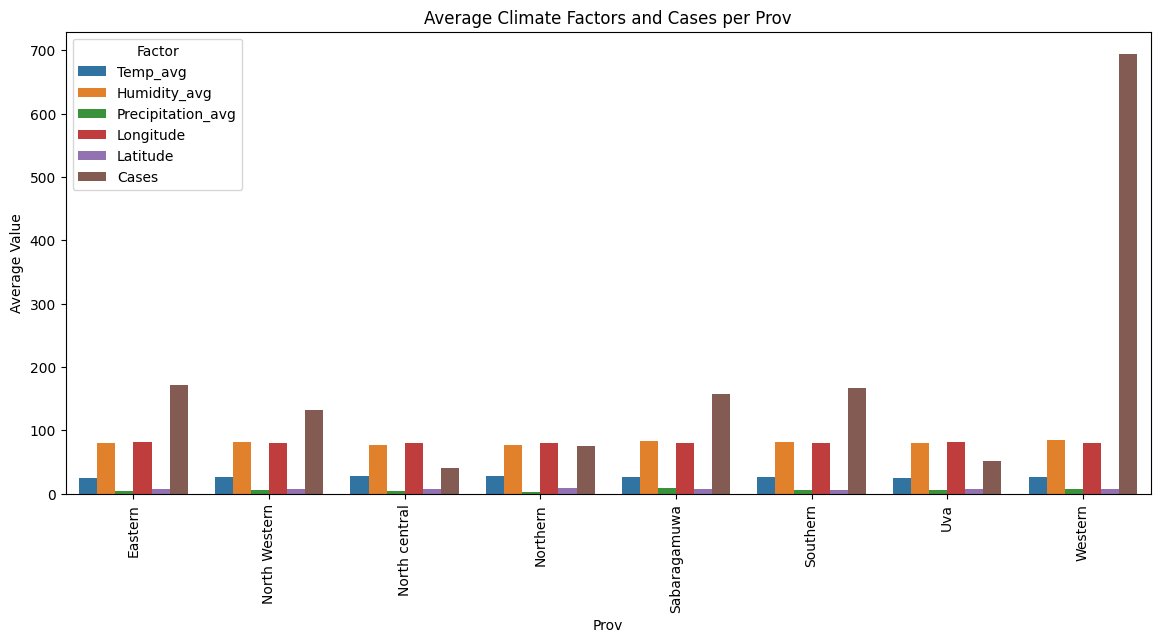

In [ ]:
df['Prov'] = df[province_columns].idxmax(axis=1).str.replace('Province_', '')
factors = df.groupby('Prov')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Longitude', 'Latitude', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Prov', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Prov', y='Average Value', hue='Factor', palette='tab10')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

### **COMPARE DISTRICT CASES TO FACTORS**

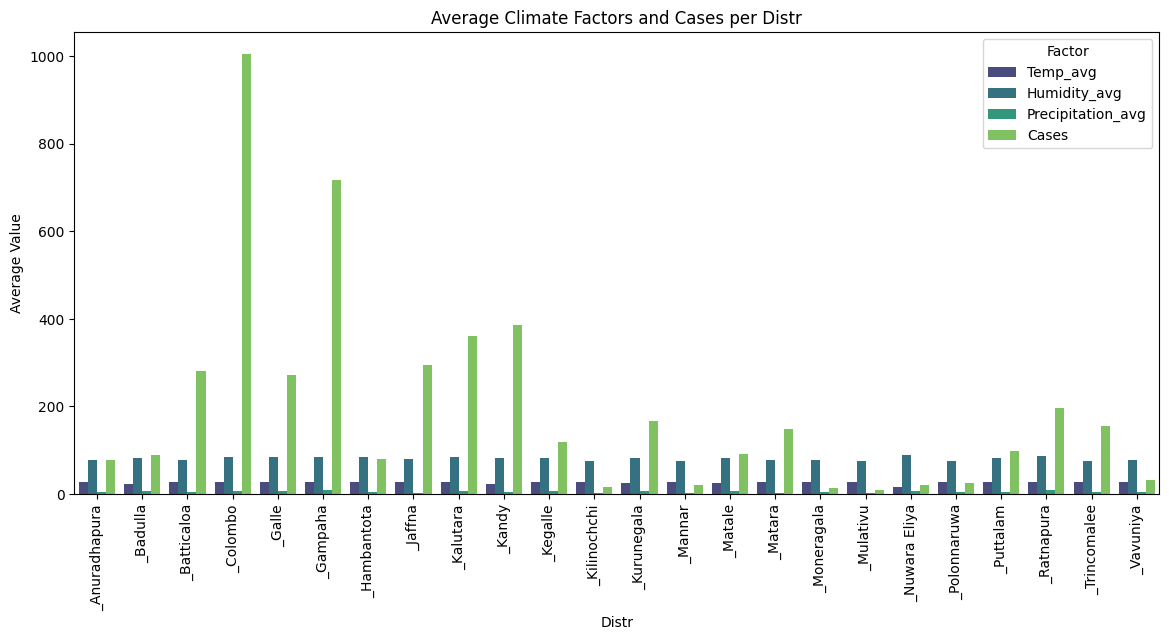

In [ ]:
df['Distr'] = df[district_columns].idxmax(axis=1).str.replace('District', '')
factors = df.groupby('Distr')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Distr', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Distr', y='Average Value', hue='Factor', palette='viridis')
plt.title('Average Climate Factors and Cases per Distr')
plt.xticks(rotation=90)
plt.show()

### **CORRELATION HEATMAP**

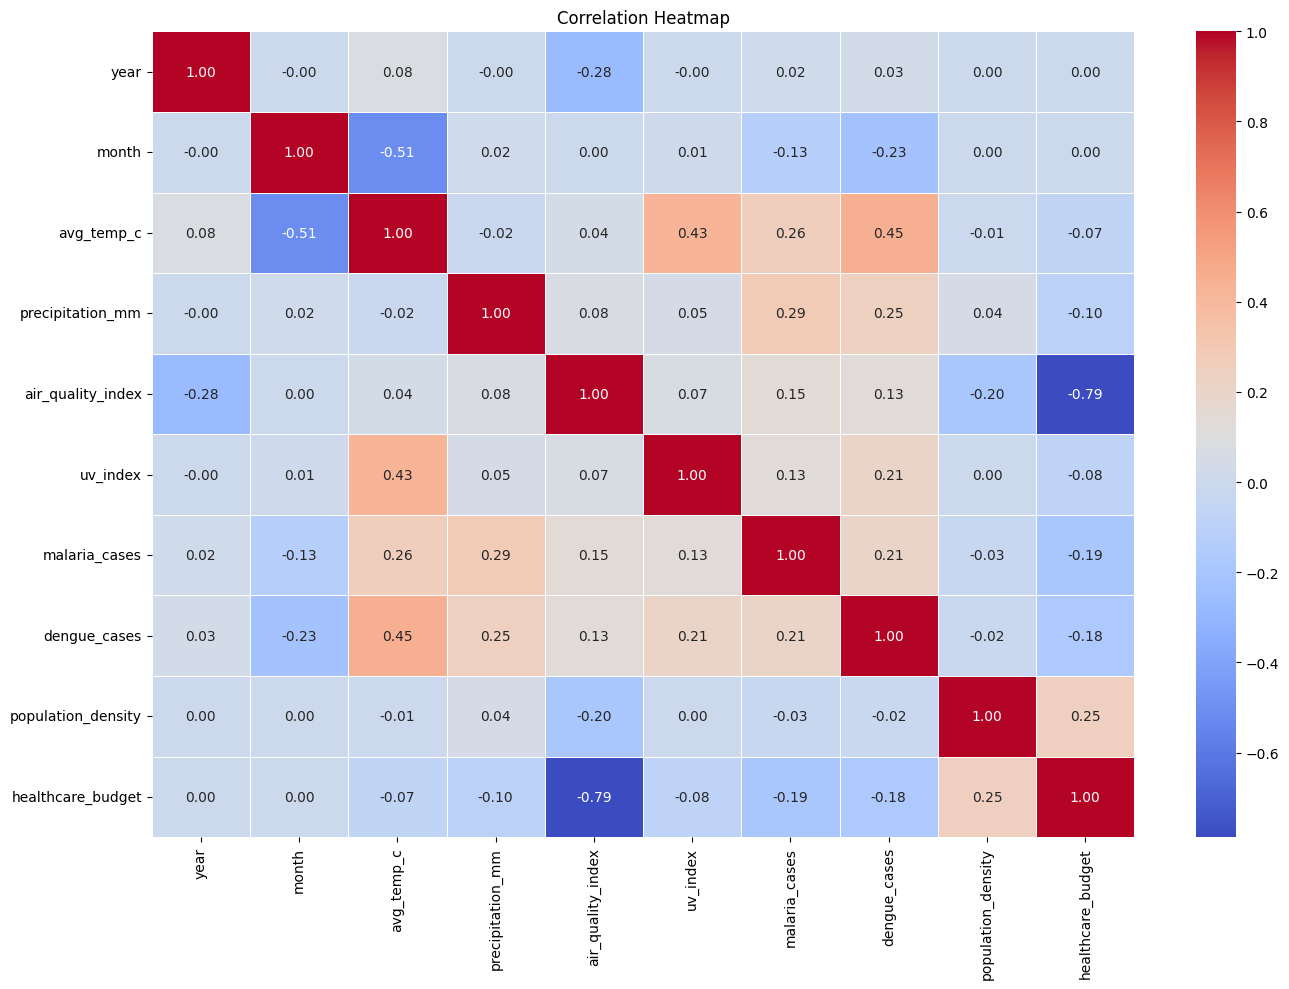

In [ ]:
df_corr = df.copy()
df_corr = pd.get_dummies(df_corr, drop_first=True)
df_corr = df_corr.select_dtypes(include='number')  # Keep only numeric columns

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# 1. Select your predictor and target
X = df[['avg_temp_c']]  # Predictor: average temperature
y = df['dengue_cases']  # Target: dengue cases

# 2. Add a constant term for the intercept
X = sm.add_constant(X)

# 3. Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# 4. Print the summary for p-value, R-squared, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           dengue_cases   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     8837.
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:08:35   Log-Likelihood:            -1.7020e+05
No. Observations:               34560   AIC:                         3.404e+05
Df Residuals:                   34558   BIC:                         3.404e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.0995      0.470     74.687      0.0

Results above for p value is <0.05 so temperature is a factor

### **----------START MODELLING-----------**

### **FEATURE IMPORTANCE**


In [ ]:
X = df.drop(columns=["dengue_cases"])
Y = df["dengue_cases"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

ValueError: Cannot cast object dtype to float32

### **RANDOM FOREST**

In [ ]:
regions = [ col for col in df.columns if col.startswith('region_')]


features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget', *regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.2609156953365225
Mean Squared Error: 1057.41386640625


In [ ]:
df = df.sort_values(by=['country', 'region', 'year', 'month']).reset_index(drop=True)

# ---- Create Lagged Features ----
df['dengue_cases_lag1'] = df['dengue_cases'].shift(1)
df['avg_temp_c_lag1'] = df['avg_temp_c'].shift(1)
df['precipitation_mm_lag1'] = df['precipitation_mm'].shift(1)
df['malaria_cases_lag1'] = df['malaria_cases'].shift(1)

# ---- Drop rows with NaNs from lagging (usually first row) ----
df = df.dropna().reset_index(drop=True)

# ---- Create Feature Interactions ----
df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
df['malaria_dengue_lag_interaction'] = df['malaria_cases_lag1'] * df['dengue_cases_lag1']
df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
df['healthcare_burden_index'] = df['population_density'] / (df['healthcare_budget'] + 1)
df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

# ---- Define Region Columns ----
regions = [col for col in df.columns if col.startswith('region_')]

# ---- Final Feature List ----
features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index', 'malaria_cases',
    'year', 'uv_index', 'population_density', 'healthcare_budget',
    'dengue_cases_lag1', 'avg_temp_c_lag1', 'precipitation_mm_lag1', 'malaria_cases_lag1',
    'temp_precip_interaction', 'malaria_dengue_lag_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction',
    'healthcare_burden_index', 'env_stress_score', *regions
]

# ---- Train-Test Split: Time-aware ----
split_index = int(0.8 * len(df))
X = df[features]
y = df['dengue_cases']
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# ---- Model Training ----
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ---- Predictions and Evaluation ----
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")


R-squared: 0.1835221776022079
Mean Squared Error: 1068.7447986689815


### **LGBM**

In [ ]:
regions = [ col for col in df.columns if col.startswith('region_')]
# df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
# df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
# df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
# df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features] = scaler.fit_transform(X_train[features])
X_test_scaled[features] = scaler.transform(X_test[features])

# X = df[features]
# Y = df['dengue_cases']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3677
[LightGBM] [Info] Number of data points in the train set: 27647, number of used features: 23
[LightGBM] [Info] Start training from score 74.540167
R-squared: 0.2043819408043871
Mean Squared Error: 1041.4399989399155


### **GRADIENT BOOSTING REGRESSOR**

In [ ]:
features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget',*regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.279521621692142
Mean Squared Error: 1006.8526748174186


### **XG BOOST**

In [ ]:
features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget',*regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.23324722051620483
Mean Squared Error: 1071.5201416015625


### **FACEBOOK PROPHET**

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vcoui8g/4rp23ybd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vcoui8g/99b52aak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13922', 'data', 'file=/tmp/tmp6vcoui8g/4rp23ybd.json', 'init=/tmp/tmp6vcoui8g/99b52aak.json', 'output', 'file=/tmp/tmp6vcoui8g/prophet_modelgrk_ug59/prophet_model-20250708205554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   yhat  yhat_lower  yhat_upper
292 2024-08-01 72.217      26.282     114.986
293 2024-09-01 69.428      25.690     118.974
294 2024-10-01 69.627      24.875     114.625
295 2024-11-01 73.950      31.888     118.751
296 2024-12-01 82.007      35.409     127.623


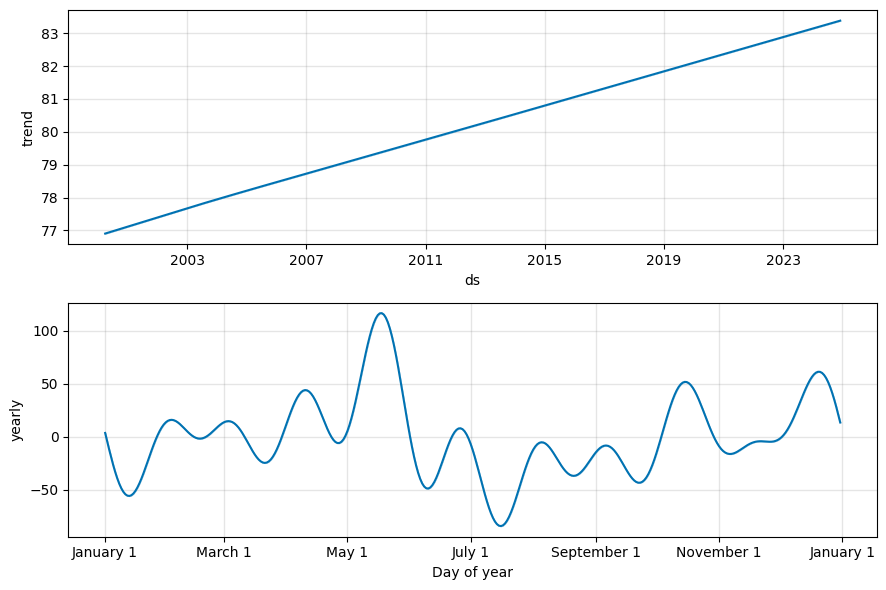

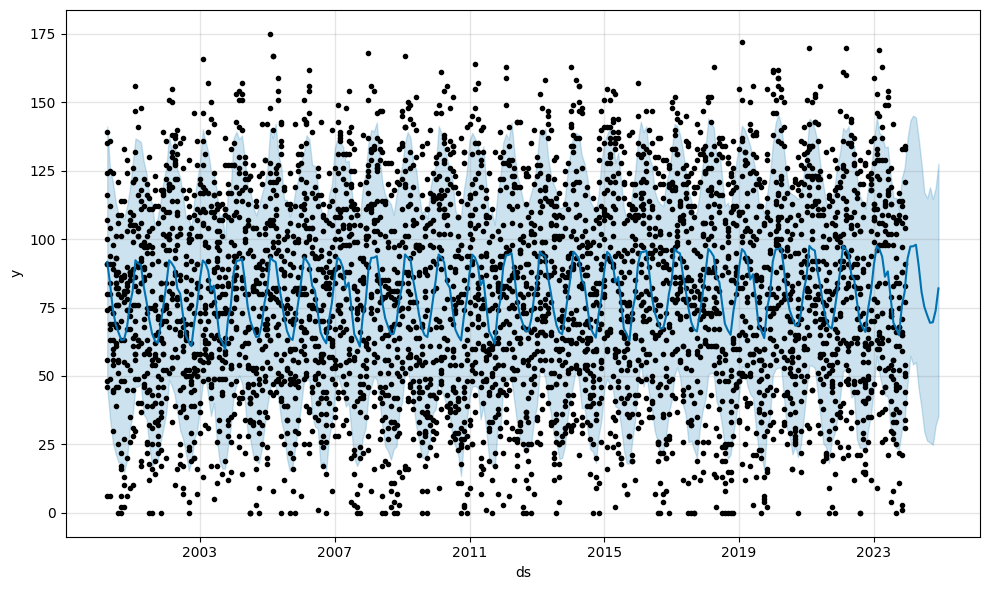

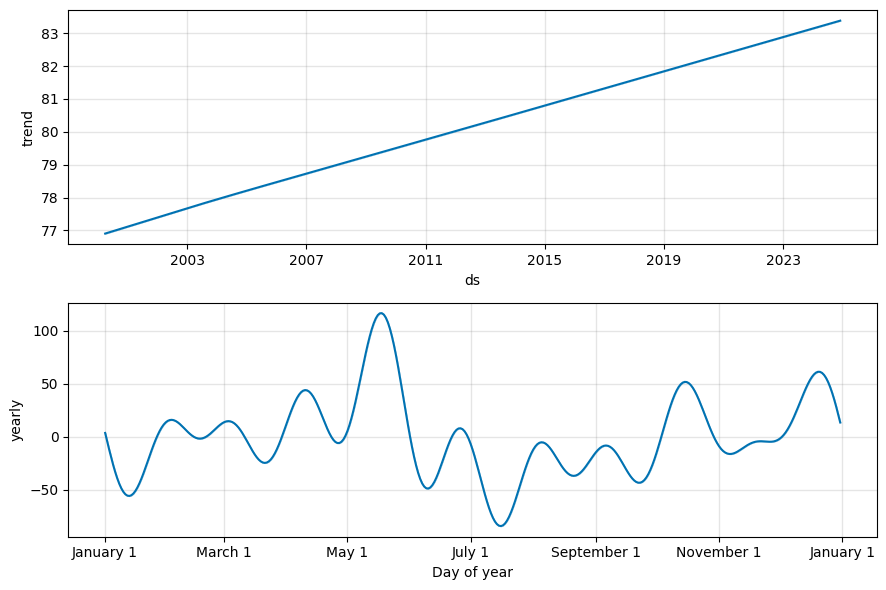

In [ ]:
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values(by='ds')

regions = [col for col in df.columns if col.startswith('region_')]
df_prophet = df[['ds', 'dengue_cases', 'country'] + regions].copy()
df_prophet = df_prophet.rename(columns={'dengue_cases': 'y'})

region_df = df_prophet[df_prophet['region_East'] == True].dropna(subset=['y'])


model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(region_df)

future = model.make_future_dataframe(periods=12, freq='MS')

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

model.plot(forecast)
model.plot_components(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4pmtlvss/e931jw9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4pmtlvss/mava2g7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43218', 'data', 'file=/tmp/tmp4pmtlvss/e931jw9_.json', 'init=/tmp/tmp4pmtlvss/mava2g7i.json', 'output', 'file=/tmp/tmp4pmtlvss/prophet_modelv44t7inw/prophet_model-20250709222331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


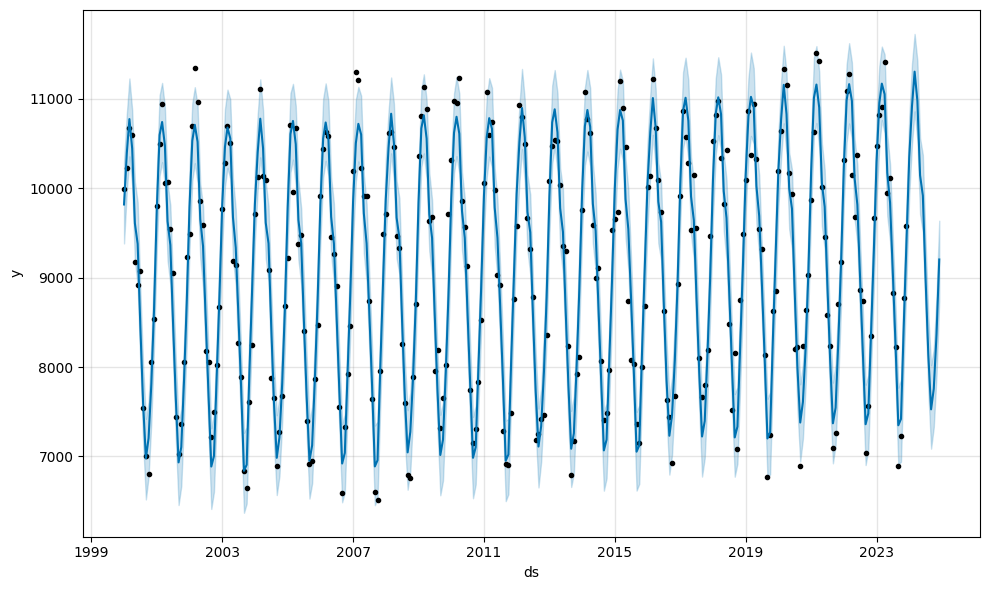

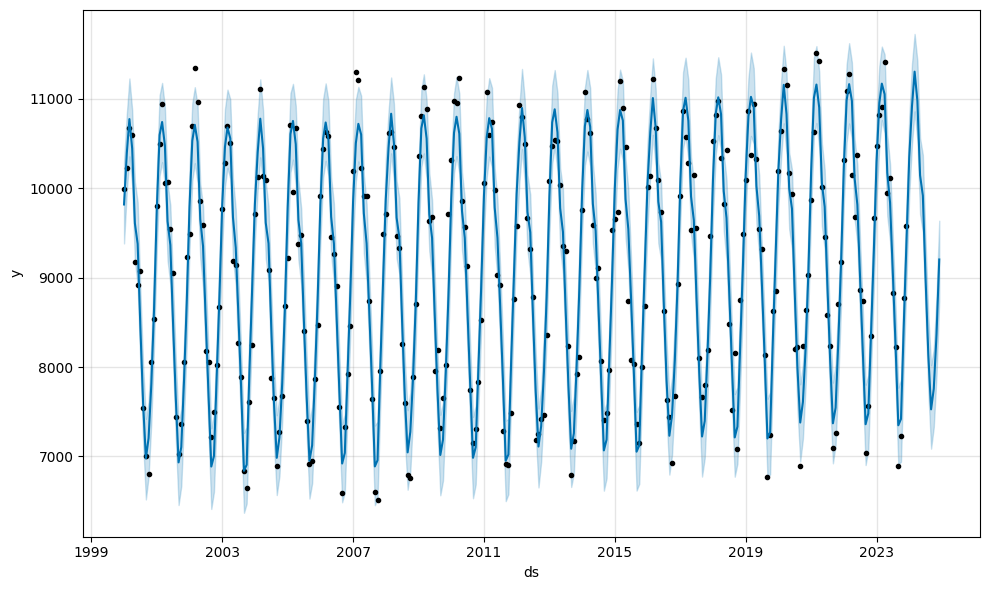

In [ ]:
from prophet import Prophet

# Prepare time series data
df_prophet = df.groupby(['year', 'month'])['dengue_cases'].sum().reset_index()
df_prophet['ds'] = pd.to_datetime(df_prophet[['year', 'month']].assign(day=1))
df_prophet['y'] = df_prophet['dengue_cases']
df_prophet = df_prophet[['ds', 'y']]

# Fit the model
model = Prophet()
model.fit(df_prophet)

# Create future dataframe (e.g., 12 months ahead)
future = model.make_future_dataframe(periods=12, freq='MS')

# Predict
forecast = model.predict(future)

# Plot
model.plot(forecast)



Initializing and training Prophet model...
Model training complete.

Generating future predictions...
Forecast generated.

Plotting forecast...


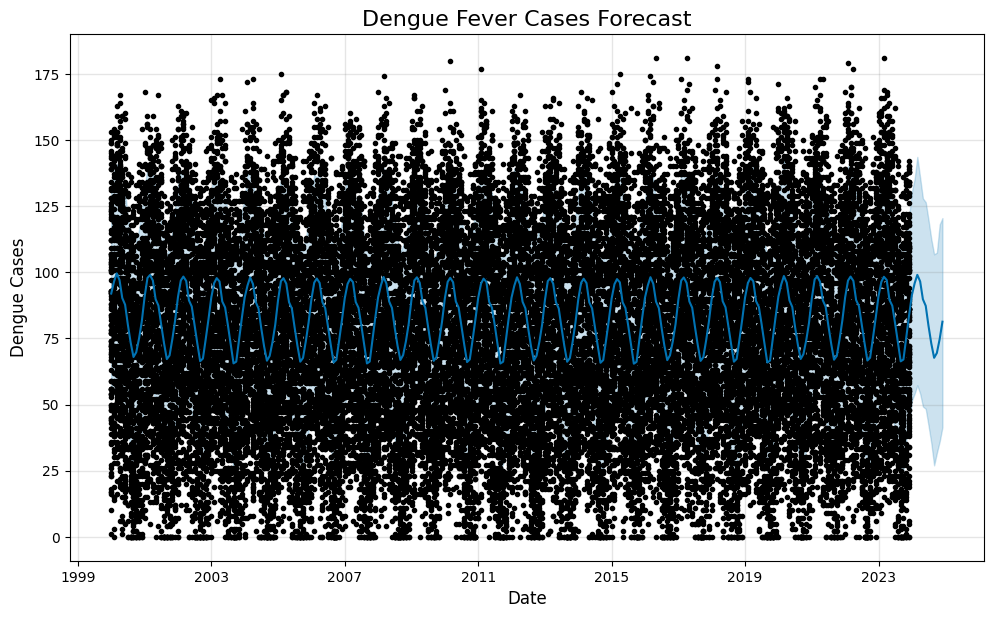

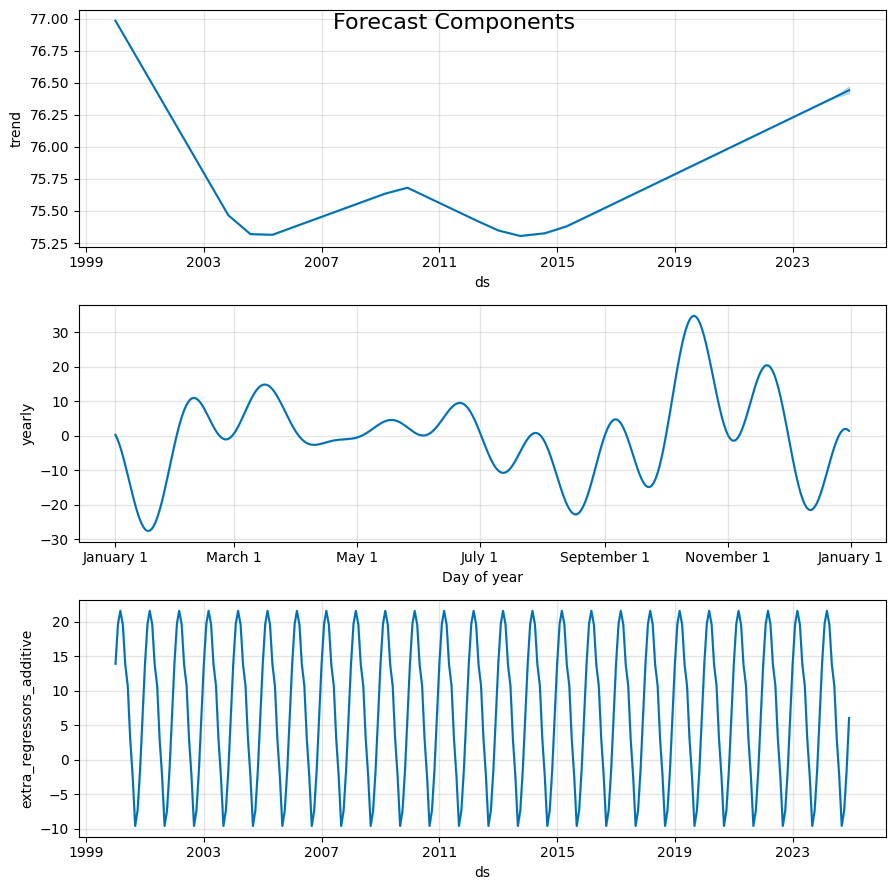


Future Dengue Cases Forecast (Last 12 Months):
        ds   yhat  yhat_lower  yhat_upper
2024-01-01 91.288      51.498     130.375
2024-02-01 95.869      54.155     135.340
2024-03-01 99.010      57.257     143.595
2024-04-01 96.521      54.097     135.701
2024-05-01 89.784      49.261     127.923
2024-06-01 87.309      48.366     126.475
2024-07-01 79.834      42.155     119.891
2024-08-01 73.041      35.431     112.535
2024-09-01 67.655      26.989     106.763
2024-10-01 69.480      31.736     107.403
2024-11-01 74.767      36.058     118.068
2024-12-01 81.303      41.451     120.472

Script execution complete.


In [62]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import logging

logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df = df.rename(columns={'dengue_cases': 'y'})

prophet_df = df[['ds', 'y', 'avg_temp_c', 'precipitation_mm',
                 'air_quality_index', 'uv_index', 'malaria_cases',
                 'population_density', 'healthcare_budget']].copy()

for col in ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']:
    prophet_df[col] = pd.to_numeric(prophet_df[col], errors='coerce')

    if prophet_df[col].isnull().any():
        prophet_df[col] = prophet_df[col].fillna(prophet_df[col].mean())
        print(f"Warning: NaNs found and filled in column '{col}'.")



print("\nInitializing and training Prophet model...")
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)


regressors = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
              'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']
for col in regressors:
    m.add_regressor(col)

m.fit(prophet_df)
print("Model training complete.")

print("\nGenerating future predictions...")

future_periods = 12
future = m.make_future_dataframe(periods=future_periods, freq='MS')

last_known_values = prophet_df[regressors].iloc[-1].to_dict()
for col in regressors:
    if col not in ['avg_temp_c', 'precipitation_mm']:
        future[col] = future['ds'].apply(lambda x: last_known_values.get(col))

prophet_df['month'] = prophet_df['ds'].dt.month
monthly_averages = prophet_df.groupby('month')[['avg_temp_c', 'precipitation_mm']].mean().reset_index()

future['month'] = future['ds'].dt.month
for col in ['avg_temp_c', 'precipitation_mm']:
    future = pd.merge(future, monthly_averages[['month', col]], on='month', how='left', suffixes=('', '_avg_merged'))
    future[col] = future[f'{col}']

cols_to_drop = [f'{col}_avg_merged' for col in ['avg_temp_c', 'precipitation_mm']] + ['month']
future = future.drop(columns=cols_to_drop, errors='ignore')

for col in regressors:
    if col not in future.columns:
        future[col] = prophet_df[col].iloc[-1]
    future[col] = pd.to_numeric(future[col], errors='coerce').fillna(prophet_df[col].mean()) # Final NaN check

forecast = m.predict(future)
print("Forecast generated.")

print("\nPlotting forecast...")
fig1 = m.plot(forecast)
plt.title('Dengue Fever Cases Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dengue Cases', fontsize=12)
plt.grid(True)
plt.show()

fig2 = m.plot_components(forecast)
plt.suptitle('Forecast Components', fontsize=16)
plt.show()

print("\nFuture Dengue Cases Forecast (Last 12 Months):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_periods).to_string(index=False))

print("\nScript execution complete.")

### **FORECAST PER FOR COUNTRY**


Initializing and training Prophet model...
Model training complete.

Generating future predictions...
Forecast generated.

Plotting forecast...


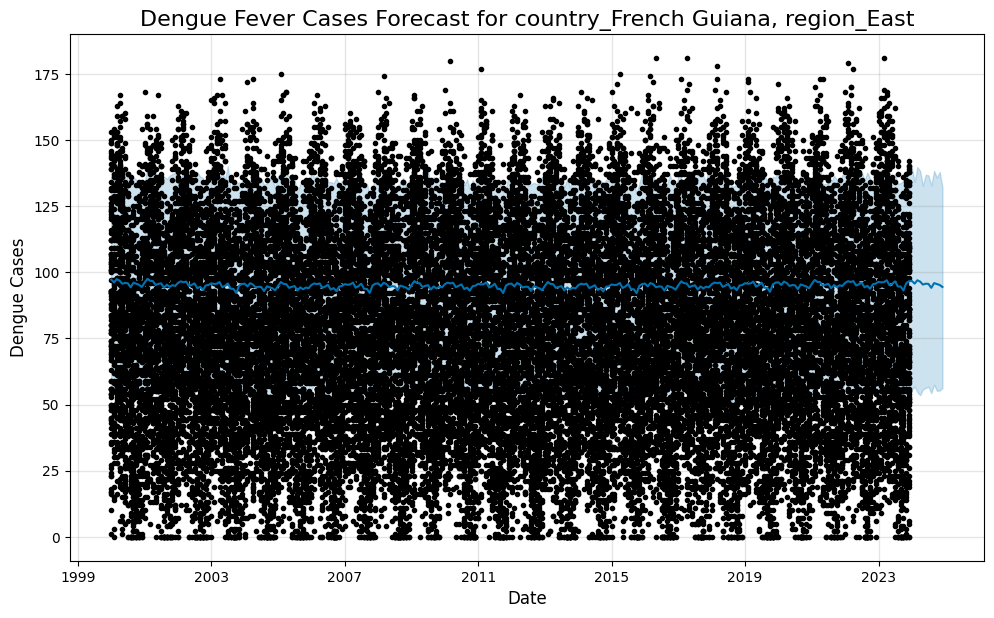

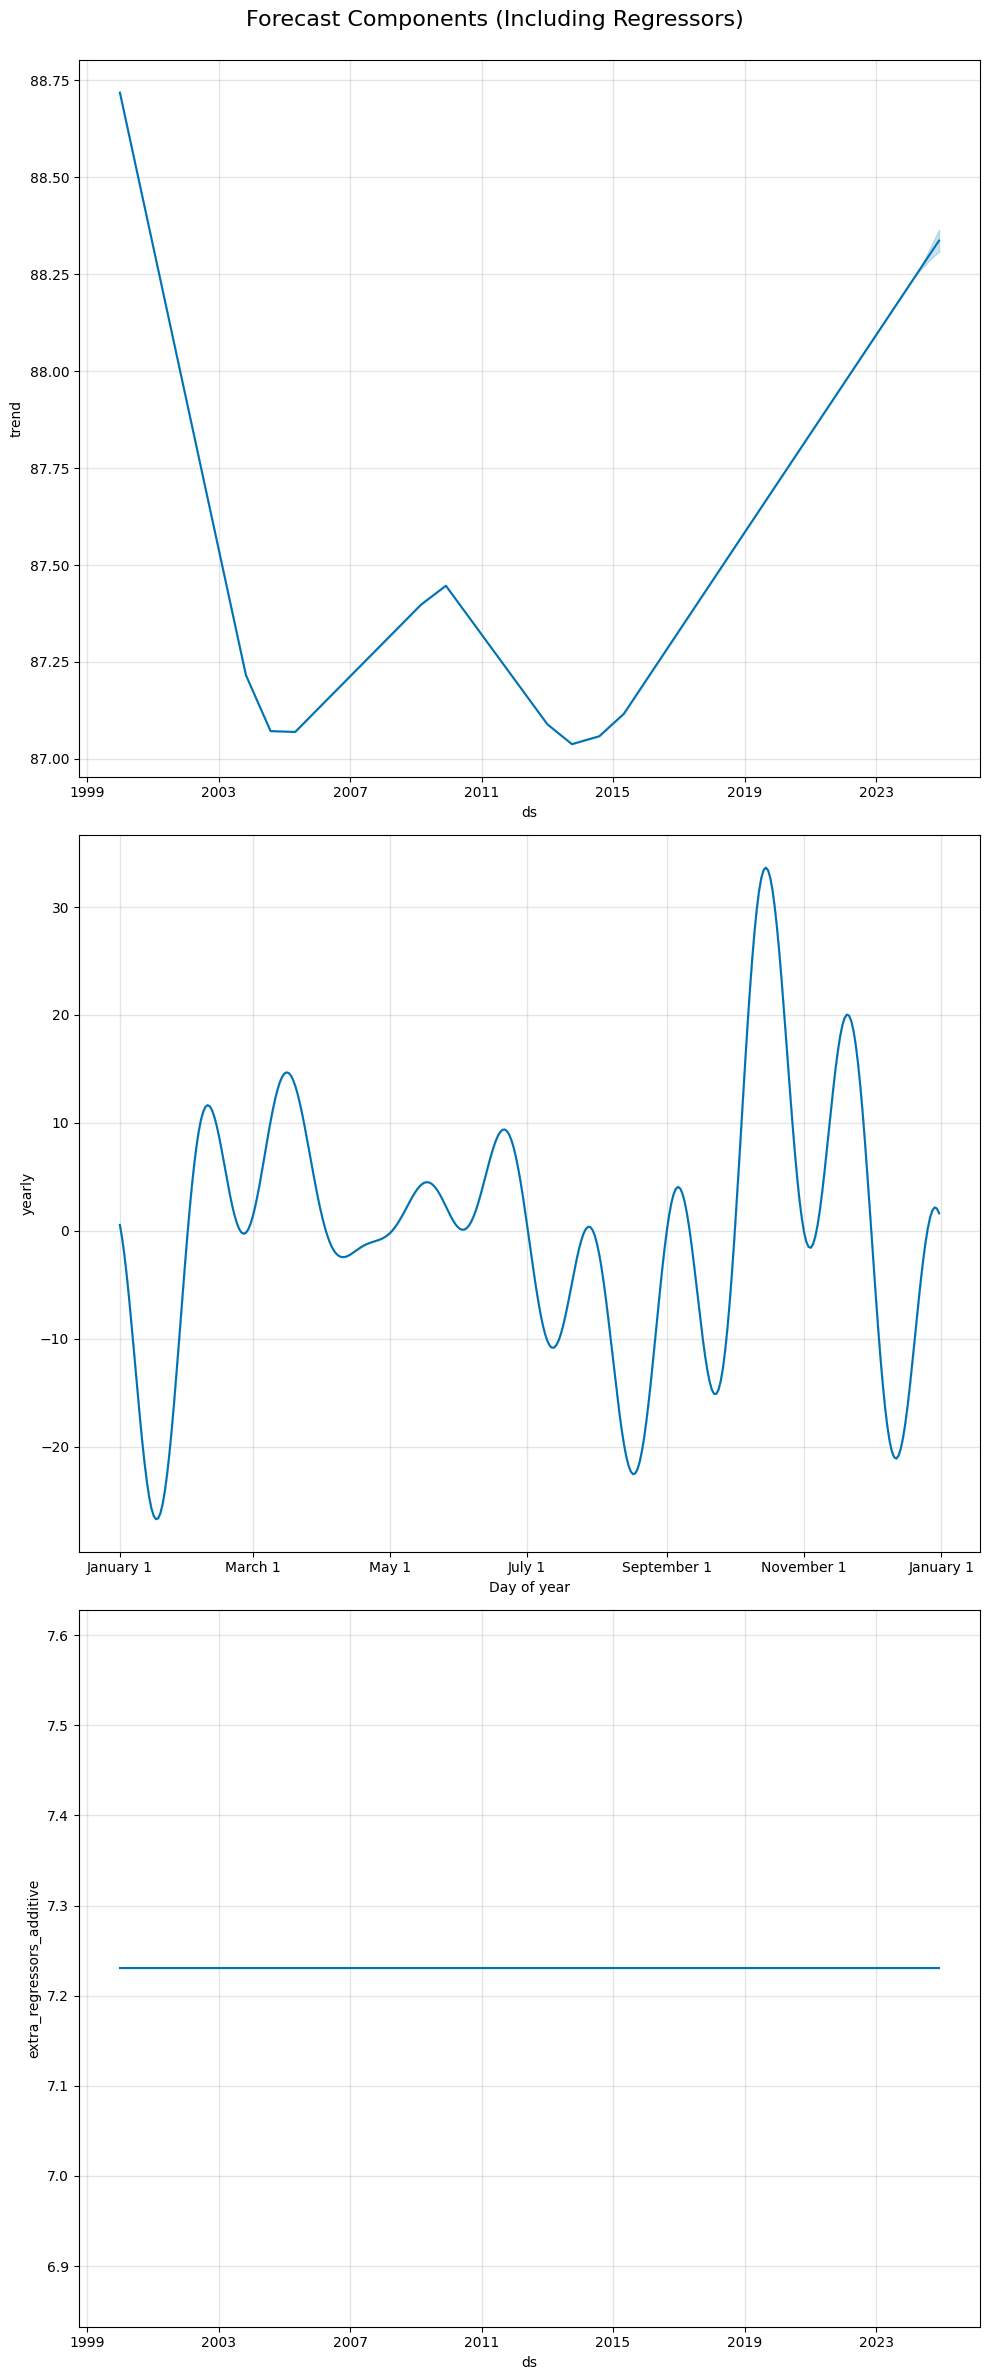


Future Dengue Cases Forecast for country_French Guiana, region_East (Next 12 Months):
        ds   yhat  yhat_lower  yhat_upper
2024-01-01 96.710      55.571     139.554
2024-02-01 95.687      56.751     134.170
2024-03-01 96.965      54.707     139.736
2024-04-01 96.452      53.512     138.295
2024-05-01 95.332      55.685     132.732
2024-06-01 95.666      56.245     136.844
2024-07-01 95.583      56.698     136.614
2024-08-01 94.104      54.290     132.834
2024-09-01 95.892      57.486     138.326
2024-10-01 95.546      55.189     135.771
2024-11-01 95.176      55.281     137.892
2024-12-01 94.419      56.223     132.145

Script execution complete.


In [75]:
country_columns = [col for col in df.columns if col.startswith('country_')]
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df = df.rename(columns={'dengue_cases': 'y'})

df_encoded = pd.get_dummies(df, columns=['country', 'region'], prefix=['country', 'region'])

original_regressors = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
                       'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']

encoded_regressor_cols = [col for col in df_encoded.columns if col.startswith('country_') or col.startswith('region_')]

all_regressors = original_regressors + encoded_regressor_cols

prophet_df = df_encoded[['ds', 'y'] + all_regressors].copy()

for col in all_regressors:
    prophet_df[col] = pd.to_numeric(prophet_df[col], errors='coerce')
    if prophet_df[col].isnull().any():
        if col in encoded_regressor_cols:
            prophet_df[col] = prophet_df[col].fillna(0)
        else:
            prophet_df[col] = prophet_df[col].fillna(prophet_df[col].mean())
        print(f"Warning: NaNs found and filled in column '{col}'.")


print("\nInitializing and training Prophet model...")
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

for col in all_regressors:
    m.add_regressor(col)

m.fit(prophet_df)
print("Model training complete.")


print("\nGenerating future predictions...")

future_periods = 12

future = m.make_future_dataframe(periods=future_periods, freq='MS')

last_known_values_global = prophet_df[original_regressors].iloc[-1].to_dict()


prophet_df['month'] = prophet_df['ds'].dt.month
monthly_averages_global = prophet_df.groupby('month')[['avg_temp_c', 'precipitation_mm']].mean().reset_index()

future['month'] = future['ds'].dt.month
for col in ['avg_temp_c', 'precipitation_mm']:
    future = pd.merge(future, monthly_averages_global[['month', col]], on='month', how='left', suffixes=('', '_avg_merged'))
    future[col] = future[f'{col}']
    future = future.drop(columns=[f'{col}'])

for col in original_regressors:
    if col not in ['avg_temp_c', 'precipitation_mm']:
        future[col] = future['ds'].apply(lambda x: last_known_values_global.get(col))

TARGET_COUNTRY = 'country_French Guiana'
TARGET_REGION = 'region_East'

for col in encoded_regressor_cols:
    if col == f'country_{TARGET_COUNTRY}':
        future[col] = 1
    else:
        future[col] = 0

for col in all_regressors:
    if col not in future.columns:
        print(f"Warning: Regressor '{col}' missing from 'future' DataFrame. Filling with mean.")
        future[col] = prophet_df[col].mean()

    future[col] = pd.to_numeric(future[col], errors='coerce').fillna(prophet_df[col].mean()) # Ensure numeric and no NaNs


future = future.drop(columns=['month'], errors='ignore')

forecast = m.predict(future)
print("Forecast generated.")


print("\nPlotting forecast...")
fig1 = m.plot(forecast)
plt.title(f'Dengue Fever Cases Forecast for {TARGET_COUNTRY}, {TARGET_REGION}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dengue Cases', fontsize=12)
plt.grid(True)
plt.show()

fig2 = m.plot_components(forecast)
fig2.set_size_inches(10, 25)
plt.suptitle('Forecast Components (Including Regressors)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print(f"\nFuture Dengue Cases Forecast for {TARGET_COUNTRY}, {TARGET_REGION} (Next {future_periods} Months):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_periods).to_string(index=False))

print("\nScript execution complete.")